In [1]:
import pandas as pd
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop


from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
# from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

In [97]:
base_dir = "C:/Users/danie/OneDrive/Documents/unsw/Subjects/ZZSC9020 Capstone Project/project/GroupF_Project/"

#Load dataset into a pandas dataframe
df_raw = pd.read_csv(base_dir + "data/Cleaned data/data.csv", index_col = 5) 
print(len(df_raw))
df_raw.dropna(inplace = True)
print(len(df_raw))
df_raw.head()

df_raw.drop('MONTHDATE', axis=1, inplace=True)

2376
2376


In [98]:
df_raw.columns

Index(['YEAR', 'MONTH', 'DAY', 'HUMIDITY', 'WINDSPEED', 'TOTALDEMAND',
       'HOLIDAY', 'MIN', 'MAX', 'RAIN', 'SOLAR', 'RRP', 'FORECASTDEMAND',
       'OUTPUT', 'WEEKDAY', 'WEEKEND', 'TEMPAVE'],
      dtype='object')

In [99]:
pd.set_option('display.max_columns', None)

In [109]:
weekday_df
weekday_df.index = df_raw.index
weekday_df

,MON,TUE,WED,THU,FRI,SAT,SUN
DATE,,,,,,,
2016-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-07-28,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-07-29,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-07-30,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [117]:
# Onehot Encoding for categorial data (Weekday)

# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df_raw[['WEEKDAY']]

# Create a one-hot encoder object
encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df_raw[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
weekday_df.index = df_raw.index

# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df_raw, weekday_df], axis=1)

#Drop weekday column
df = df.drop(['WEEKDAY'], axis=1)

df.index = pd.to_datetime(df.index)

df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,MIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,WEEKEND,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
DATE,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2016,1,1,0.656341,15.902439,6853.633437,2.0,15.3,28.6,0.0,32.2,38.472917,6665.366167,23.465,0,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-01-02,2016,1,2,0.656341,15.902439,6727.613958,0.0,15.9,26.1,0.0,21.7,36.907292,6236.849955,23.465,1,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-01-03,2016,1,3,0.688837,14.488372,6616.406076,0.0,17.5,25.6,0.0,10.3,31.997083,6551.924748,23.465,1,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-01-04,2016,1,4,0.679545,22.477273,7367.750278,0.0,18.2,23.6,14.0,6.4,33.424583,6729.993123,23.465,0,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,2016,1,5,0.768837,22.581395,7462.242014,0.0,17.6,20.5,39.0,4.4,33.053958,7333.898202,23.465,0,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# identify response variable and predictors
train_from_date = '2016-01-01'
train_to_date = '2020-12-31'

test_from_date = '2021-01-01'
test_to_date = '2021-12-31'


# Split the dataset into training and testing sets
X_train = df[(df.index>=train_from_date) & (df.index<=train_to_date)].drop(['TOTALDEMAND'], axis=1)
y_train = df[(df.index>=train_from_date) & (df.index<=train_to_date)]['TOTALDEMAND']

X_train_arr = X_train.values
y_train_arr = y_train.values

X_test = df[(df.index>=test_from_date) & (df.index<=test_to_date)].drop(['TOTALDEMAND'], axis=1)
y_test = df[(df.index>=test_from_date) & (df.index<=test_to_date)]['TOTALDEMAND']

X_test_arr = X_test.values
y_test_arr = y_test.values

print(len(X_train_arr), len(X_test_arr))

1827 365


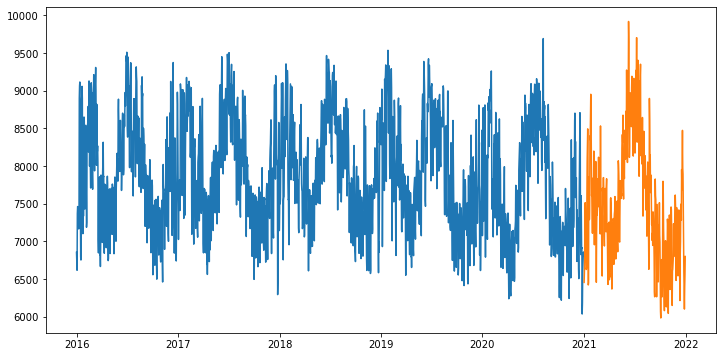

In [127]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(X_train.index, y_train_arr)
plt.plot(X_test.index, y_test_arr)
plt.show()

In [128]:
# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(X_train_scaled[:5])

[[0.         0.         0.         0.67916128 0.35931915 1.
  0.56610169 0.60851064 0.         1.         0.13444934 0.6199212
  0.02498683 0.         0.6380814  0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.03333333 0.67916128 0.35931915 0.
  0.58644068 0.55531915 0.         0.67391304 0.11999666 0.58006648
  0.02498683 1.         0.61046512 0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.         0.06666667 0.71278685 0.32736799 0.
  0.64067797 0.54468085 0.         0.31987578 0.07466929 0.60937043
  0.02498683 1.         0.62645349 0.         0.         0.
  0.         0.         0.         1.        ]
 [0.         0.         0.1        0.70317203 0.50787898 0.
  0.66440678 0.50212766 0.0877193  0.19875776 0.0878469  0.62593192
  0.02498683 0.         0.60755814 1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.13333333 0.7955683  0.51023166 0.
 

In [129]:
#Reshape the data for input to the LSTM model
#(This step is fit the data to 3D tensor format for LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)


X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1:i, :])
    y_train.append(X_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1:i, :])
    y_test.append(X_test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

print(X_test[:5])

[[[1.25       0.         0.         0.74930716 0.52509333 1.
   0.64745763 0.47234043 0.         0.16459627 0.0700979  0.60342464
   0.6830742  0.         0.57994186 0.         0.         0.
   0.         1.         0.         0.        ]]

 [[1.25       0.         0.03333333 0.74930716 0.52509333 0.
   0.60677966 0.4893617  0.00125313 0.31055901 0.06609577 0.60667605
   0.6830742  1.         0.57412791 0.         0.         0.
   0.         0.         1.         0.        ]]

 [[1.25       0.         0.06666667 0.91183775 0.36920594 0.
   0.63389831 0.57446809 0.01629073 0.3757764  0.04864101 0.62792975
   0.6830742  1.         0.64389535 0.         0.         0.
   0.         0.         0.         1.        ]]

 [[1.25       0.         0.1        0.89394976 0.44306285 0.
   0.6779661  0.62765957 0.00250627 0.3447205  0.11257512 0.69623471
   0.6830742  0.         0.69912791 1.         0.         0.
   0.         0.         0.         0.        ]]

 [[1.25       0.         0.13333333 

In [130]:
# Build the LSTM model with three LSTM layers and one dense output layer

model = Sequential()
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(LSTM(units=16, activation='relu'))
model.add(Dense(units=1, activation='linear'))


optimizer = RMSprop(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [131]:
# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 11s 27ms/step - loss: 0.3672
Epoch 2/100
58/58 [==============================] - 1s 23ms/step - loss: 0.3539
Epoch 3/100
58/58 [==============================] - 1s 24ms/step - loss: 0.3387
Epoch 4/100
58/58 [==============================] - 1s 25ms/step - loss: 0.3201
Epoch 5/100
58/58 [==============================] - 2s 27ms/step - loss: 0.2973
Epoch 6/100
58/58 [==============================] - 1s 25ms/step - loss: 0.2685
Epoch 7/100
58/58 [==============================] - 2s 26ms/step - loss: 0.2342
Epoch 8/100
58/58 [==============================] - 1s 24ms/step - loss: 0.1948
Epoch 9/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1543
Epoch 10/100
58/58 [==============================] - 1s 22ms/step - loss: 0.1222
Epoch 11/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1078
Epoch 12/100
58/58 [==============================] - 1s 23ms/step - loss: 0.1029
Epoch 13/100
58/58 [====

58/58 [==============================] - 1s 23ms/step - loss: 2.2729e-04
Epoch 99/100
58/58 [==============================] - 1s 22ms/step - loss: 2.2865e-04
Epoch 100/100
58/58 [==============================] - 1s 23ms/step - loss: 2.2312e-04


In [132]:
# Evaluate the LSTM model

# Get model predictions on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

MSE: 0.0008
R-squared: 0.0000
